In [245]:
# -*- coding:utf-8 -*-
import os
import numpy as np
from numpy.linalg import eig
from skimage.color import rgb2ycbcr
from skimage.color import ycbcr2rgb
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
from scipy.misc import imresize
from scipy.signal import convolve
from skimage.util import view_as_windows
import  skimage.io as io
from skimage import data_dir
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import spams

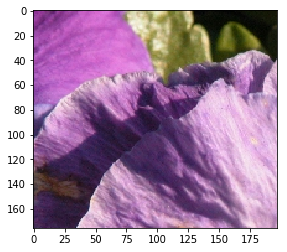

In [167]:
str = '/Users/shanlinsun/Documents/GitHub/Single_Image_SR/CVPR08-SR/Data/Training/*.bmp'
coll = io.ImageCollection(str)
plt.imshow(coll[0])

In [168]:
nSmp = 100000
nSmp_array = np.zeros(len(coll))
nShape_array = np.zeros(len(coll))
for i in range(len(coll)):
    nShape_array[i] = coll[i].size
nSmp_array = np.floor(nSmp*nShape_array/sum(nShape_array))

In [169]:
dic_size = 1000
upscale = 3
patch_size = 3
overlap = 1
filters = [[[1,0,0,-1]],[[1],[0],[0],[-1]],[[0.5,0,0,-1,0,0,0.5]],[[0.5],[0],[0],[-1],[0],[0],[0.5]]]

In [170]:
def modcrop(Input_Img, upscale):
    mod = np.remainder(Input_Img.shape, upscale)
    new_shape = Input_Img.shape - mod
    Output_Img = Input_Img[0:new_shape[0], 0:new_shape[1]]
    
    return Output_Img

In [171]:
window_size = patch_size * upscale
step = (patch_size - overlap) * upscale
for i in range(len(coll)):
    
    # convert rgb image to YCcCr color space
    if coll[i].shape[2] == 3:
        H_Img = rgb2ycbcr(coll[i])
        # only keep y-channle for 'texture'
        H_Img = H_Img[:,:,0]
    else:
        H_Img = coll[i]
        
    # Load training high-res. image set and resample it
    H_Img = modcrop(H_Img, upscale) # crop a bit (to simplify scaling issues)
    # Scale down images
    L_Img = imresize(H_Img, 1/upscale, interp='bicubic', mode = 'F')
    
    M_Img = imresize(L_Img, H_Img.shape, interp='bicubic', mode = 'F')
    
    # remove the low frequency content of an image
    RI_Img = H_Img - M_Img 

    # compute first order and second order gradient, 
    # generating four feature maps per low-resolution image
    M_Img_1 = convolve(M_Img, filters[0], 'same')
    M_Img_2 = convolve(M_Img, filters[1], 'same')
    M_Img_3 = convolve(M_Img, filters[2], 'same')
    M_Img_4 = convolve(M_Img, filters[3], 'same')

    # slice out low-res patches
    window_size = patch_size * upscale
    step = (patch_size - overlap) * upscale
    patch_array_1 = view_as_windows(M_Img_1, window_size, step)
    patch_array_1 = patch_array_1.reshape(-1, patch_array_1.shape[-2]*patch_array_1.shape[-1])
    patch_array_2 = view_as_windows(M_Img_2, window_size, step)
    patch_array_2 = patch_array_2.reshape(-1, patch_array_2.shape[-2]*patch_array_2.shape[-1])
    patch_array_3 = view_as_windows(M_Img_3, window_size, step)
    patch_array_3 = patch_array_3.reshape(-1, patch_array_3.shape[-2]*patch_array_3.shape[-1])
    patch_array_4 = view_as_windows(M_Img_4, window_size, step)
    patch_array_4 = patch_array_4.reshape(-1, patch_array_4.shape[-2]*patch_array_4.shape[-1])
    
    # slice out high-res patches
    patch_array_h = view_as_windows(RI_Img, window_size, step)
    patch_array_h = patch_array_h.reshape(-1, patch_array_h.shape[-2]*patch_array_h.shape[-1])

    # stack four feature maps of low-res image together
    patch_array_l = np.concatenate((patch_array_1,patch_array_2,patch_array_3,patch_array_4),axis = 1)
    
    if i == 0:
        feature_l = patch_array_l
        feature_h = patch_array_h
    else:
        feature_l = np.concatenate((feature_l,patch_array_l),axis = 0)
        feature_h = np.concatenate((feature_h,patch_array_h),axis = 0)

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [172]:
from sklearn.decomposition import PCA
clf = PCA(n_components=30)
feature_l_pca = clf.fit_transform(feature_l)

In [4]:
Dic = MiniBatchDictionaryLearning(n_components = dic_size, alpha = 0.1, batch_size = 500, n_iter = 50)
SrDc = Dic.fit(feature_l_pca)

Dl = SrDc.components_
w = sparse_encode(feature_l_pca, Dl, alpha=0.1, max_iter = 50)

from numpy.linalg import inv
Dh = np.dot(inv(np.dot(w.T, w)), np.dot(w.T, feature_h))

NameError: name 'dic_size' is not defined

In [225]:
Test_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/gnd.bmp')
Test_Img = rgb2ycbcr(Test_Img)
Test_Img_y = Test_Img[:,:,0]
Test_Img_cb = Test_Img[:,:,1]
Test_Img_cr = Test_Img[:,:,2]

In [226]:
step = 1
# Load training high-res. image set and resample it
Test_Img_y = modcrop(Test_Img_y, upscale) # crop a bit (to simplify scaling issues)
M_Img = imresize(Test_Img_y, 1/upscale, interp='bicubic', mode = 'F')
M_Img = imresize(M_Img, Test_Img_y.shape, interp='bicubic', mode = 'F')

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [227]:
M_Img = np.pad(M_Img, patch_size*upscale-step, mode='symmetric')
H_Img = np.zeros(M_Img.shape)
RI_Img = np.zeros(M_Img.shape)

In [228]:
# compute first order and second order gradient, 
# generating four feature maps per low-resolution image
M_Img_1 = convolve(M_Img, filters[0], 'same')
M_Img_2 = convolve(M_Img, filters[1], 'same')
M_Img_3 = convolve(M_Img, filters[2], 'same')
M_Img_4 = convolve(M_Img, filters[3], 'same')

In [229]:
gridx = np.arange(0, M_Img_1.shape[0]-patch_size*upscale+1,step, dtype=int)
gridy = np.arange(0, M_Img_1.shape[1]-patch_size*upscale+1,step, dtype=int)

In [230]:
window_size = patch_size*upscale
for xx in gridx:
    for yy in gridy:
        # preprocessing gradient map
        mPatchFea_1 = M_Img_1[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_1 = mPatchFea_1.flatten()
        mPatchFea_2 = M_Img_2[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_2 = mPatchFea_2.flatten()
        mPatchFea_3 = M_Img_3[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_3 = mPatchFea_3.flatten()
        mPatchFea_4 = M_Img_4[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_4 = mPatchFea_4.flatten()
        mPatchFea = np.concatenate((mPatchFea_1, mPatchFea_2, mPatchFea_3, mPatchFea_4))

        # reshape y for sparse coder requirement
        feature_l = mPatchFea.reshape(1,-1)

        # pca 324->30
        feature_l_pca = clf.transform(feature_l)

        # sparse recovery
        w = sparse_encode(feature_l_pca, Dl, alpha=0.1, max_iter = 50)
        
        # compute the residual patch
        riPatch = np.dot(w,Dh)
        
        # reshape back to the (patch_size,patch_size) patch 
        riPatch = riPatch.reshape(window_size, window_size)
        
        # patch residual patch onto the image
        RI_Img[xx:xx+window_size,yy:yy+window_size] += riPatch

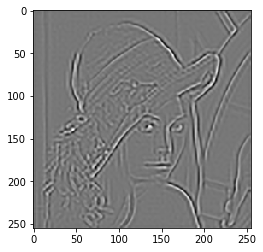

In [251]:
ri_Img = RI_Img[window_size-1:-window_size+1,window_size-1:-window_size+1]/81
plt.imshow(ri_Img, cmap='gray')

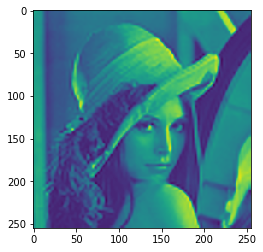

In [232]:
Bi_Img = M_Img[window_size-1:-window_size+1,window_size-1:-window_size+1]
h_Img = ri_Img + Bi_Img
plt.imshow(h_Img)

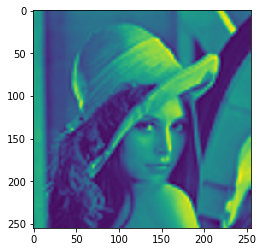

In [233]:
plt.imshow(Bi_Img)

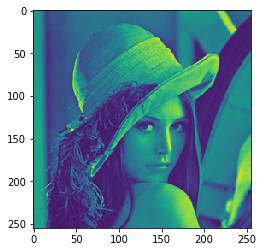

In [234]:
plt.imshow(Test_Img_y)

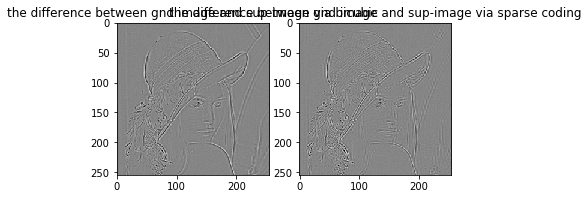

In [235]:
plt.subplot(1,2,1)
plt.title('the difference between gnd image and sup-image via bicubic')
plt.imshow(Bi_Img-Test_Img_y,cmap = 'gray')
plt.subplot(1,2,2)
plt.title('the difference between gnd image and sup-image via sparse coding')
plt.imshow(h_Img-Test_Img_y,cmap = 'gray')

In [249]:
psnr = compare_psnr(Test_Img_y.astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
ssim = compare_ssim(Test_Img_y.astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
print('srsc_v2_upscale_3, psnr:', psnr)
print('srsc_v2_upscale_3, ssim:', ssim)

srsc_v2_upscale_3, psnr: 28.315531176122054
srsc_v2_upscale_3, ssim: 0.8553629316222439


In [250]:
psnr = compare_psnr(Test_Img_y.astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
ssim = compare_ssim(Test_Img_y.astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
print('bicubic_upscale_3, psnr:', psnr)
print('bicubic_upscale_3, ssim:', ssim)

bicubic_upscale_3, psnr: 26.100461070663815
bicubic_upscale_3, ssim: 0.8147941229354244
